# Neural Machine Translation with Transformers

In the universe of natural language processing (NLP), text classification is a relatively simple task. At the opposite end of the difficulty spectrum lies neural machine translation (NMT), which uses deep learning to translate text from one language to another – for example, turning “Hello world” into “Salut le monde.” NMT has proven superior to the [rules-based machine translation](https://en.wikipedia.org/wiki/Rule-based_machine_translation) (RBMT) and [statistical machine translation](https://en.wikipedia.org/wiki/Statistical_machine_translation) (SMT) systems that predated the explosion of deep learning and today is the basis for virtually all state-of-the-art text-translation services. Let's use Keras and TensorFlow to build an NMT model that translates English to French. This exercise requires [Keras-nlp](https://pypi.org/project/keras-nlp/), so be sure to install it if it isn't installed already.

## Load and prepare the data

**en-fr.txt** is a subset of a [larger file](http://www.manythings.org/anki/fra-eng.zip) containing more than 190,000 phrases and their corresponding translations compiled as part of the [Tatoeba project](https://tatoeba.org/). The file is tab-delimited. Each line contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. We don’t need the attributions, so load the dataset into a Pandas DataFrame, remove the attribution column, and shuffle and reindex the rows.

In [1]:
import pandas as pd

df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


Clean the text by removing punctuation symbols and numbers, converting characters to lowercase, and replacing Unicode characters with their ASCII equivalents. For the French samples, insert [start] and [end] tokens at the beginning and end of each phrase.

In [2]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


The next step is to scan the phrases and determine the maximum length of the English phrases and then of the French phrases. These lengths will determine the lengths of the sequences input to and output from the model:

In [3]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


Now fit one `Tokenizer` to the English phrases and another `Tokenizer` to their French equivalents, and generate padded sequences for all the phrases:

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer(oov_token='[UNK]')
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(oov_token='[UNK]', filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

Compute the vocabulary sizes from the Tokenizer instances:

In [5]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6034
Vocabulary size (French): 12198


Finally, create the features and the labels the model will be trained with. The features are the padded English sequences and the padded French sequences minus the [end] tokens. The labels are the padded French sequences minus the [start] tokens. Package the features in a dictionary so they can be input to a model that accepts multiple inputs.

In [6]:
inputs = { 'encoder_inputs': en_x, 'decoder_inputs': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

## Build and train a model

Now use Keras's functional API to define a model that includes a transformer encoder and a transformer decoder. The model accepts two inputs: padded English sequences for the encoder, and padded French sequences for the decoder. The output from the decoder is fed to a softmax output layer for classification.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder, TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_inputs = Input(shape=(None,), dtype='int64', name='encoder_inputs')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, num_heads)(x)
encoder = Model(encoder_inputs, encoder_outputs)

decoder_inputs = Input(shape=(None,), dtype='int64', name='decoder_inputs')
encoded_seq_inputs = Input(shape=(None, embed_dim), name='decoder_state_inputs')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_inputs)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_inputs, use_causal_mask=True)
x = Dropout(0.4)(x)

decoder_outputs = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

model = Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name='transformer'
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "transformer"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 encoder_inputs (InputLayer)           [(None, None)]             0             []                                      
                                                                                                                        
 token_and_position_embedding (TokenAn  (None, None, 256)         1548800       ['encoder_inputs[0][0]']                
 dPositionEmbedding)                                                                                                    
                                                                                                                        
 decoder_inputs (InputLayer)           [(None, None)]             0             []                                      
           

Train the model, and use an `EarlyStopping` callback to end training if the validation accuracy fails to improve for three consecutive epochs:

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 128s 101ms/step - loss: 1.3737 - accuracy: 0.4641 - val_loss: 0.9819 - val_accuracy: 0.5820
Epoch 2/50
1250/1250 [==============================] - 129s 104ms/step - loss: 0.8307 - accuracy: 0.6313 - val_loss: 0.7030 - val_accuracy: 0.6796
Epoch 3/50
1250/1250 [==============================] - 132s 105ms/step - loss: 0.5870 - accuracy: 0.7067 - val_loss: 0.6089 - val_accuracy: 0.7116
Epoch 4/50
1250/1250 [==============================] - 137s 110ms/step - loss: 0.4562 - accuracy: 0.7487 - val_loss: 0.5662 - val_accuracy: 0.7284
Epoch 5/50
1250/1250 [==============================] - 136s 109ms/step - loss: 0.3778 - accuracy: 0.7745 - val_loss: 0.5480 - val_accuracy: 0.7410
Epoch 6/50
1250/1250 [==============================] - 138s 111ms/step - loss: 0.3243 - accuracy: 0.7932 - val_loss: 0.5396 - val_accuracy: 0.7466
Epoch 7/50
1250/1250 [==============================] - 139s 111ms/step - loss: 0.2893 - accuracy: 0.8078 - val_

Plot the training and validation accuracy:

[]

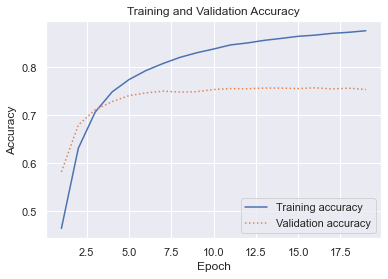

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to translate text

Can the model really translate English to French? Use a subset of the phrases reserved to validate the model to make predictions and see for yourself.

In [10]:
import numpy as np

def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]
        
        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break
    
    return decoded_text[8:-6] # Remove [start] and [end] tokens

fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
sentences = en[40000:40010].values

for sentence in sentences:
    translated = translate_text(sentence, model, en_tokenizer, fr_tokenizer, fr_index_lookup)
    print(f'{sentence} => {translated}')

its fall now => cest maintenant tombe
im losing => je suis en train de perdre
it was quite funny => ce fut assez amusant
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que je vais faire ca
tom looks different => tom a lair different
its worth a try => ca vaut le coup dessayer
fortune smiled on him => la chance lui a souri
lets hit the road => taillons la route
i love winning => jadore gagner


Finally, see how the model translates "Hello world" into French:

In [11]:
text = 'Hello world'
translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup)

'bonjour'

The model isn't perfect, but it's not bad, either. The dataset that you trained with contains just 50,000 samples, but if you trained with millions of samples, you'd have the makings of a decent NMT model.